<a href="https://colab.research.google.com/github/Ajay1994/Logical_Fallacy_Detection/blob/master/LF_Appeal_to_Fear_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir('drive/My Drive/Cognitive Vigilance/')
!pwd

/content/drive/My Drive/Cognitive Vigilance


In [0]:
import numpy as np
import pandas as pd
from datasets.myutils import *
import re
import random
from sklearn.utils import shuffle

In [3]:
print(train_folder)
articles = read_articles_from_file_list(train_folder)

datasets/train-articles


In [4]:
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))
dev_articles = read_articles_from_file_list(dev_folder)
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

Loaded 6129 annotations from 357 articles


In [0]:
def cleanText(text):
    #general 
    text = text.replace('p. m.', 'pm') 
    text = text.replace('a. m.', 'am')     
    text = re.sub(r'(\d),\s*(\d)', r'\1\2', text)  #eg 58,849357, 943589354,   845758
    
    text = re.sub('[^0-9a-zA-Z.]+' , " ", text )  #Anything not in this will be removed, eg oughout. • As -> oughout. As
    text = re.sub(r'[.]{2,}', '', text) #  . ..
    text = re.sub(r'\s([?.!",](?:\s|$))', r'\1', text)   #remove whitespace before punctuations but not after
    text = text.strip()   #Remove leading and trailing spaces
    text = re.sub(' +',' ', text)  #remove extra whitespaces
    return text

In [0]:
def _getTrainDataFrame(full_text=True):
    negative_samples = []
    print(len(ref_articles_id))
    print(len(ref_span_starts))
    print(len(ref_span_ends))
    print(len(train_gold_labels))
    traindata = []
    for idx, strt, end, label in zip(ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels):
        tempdata = {}
        tempdata['id'] = idx
        tempdata['strt'] = int(strt)
        tempdata['end'] = int(end)
        tempdata['label'] = label
        articletext = articles[idx]
        tempdata['text'] = articletext[tempdata['strt']:tempdata['end']]

        if full_text == True:
            tempdata['full_text'] = tempdata['text'].replace("\n", " ")
            articletext = articletext.replace("\n\n", "\n")
            #articletext = cleanText(articletext)
            sentences = articletext.split("\n")
            for s in sentences:
                if s.find(tempdata["text"]) != -1:
                    tempdata['full_text'] = cleanText(s)
                elif len(s) > 0 and random.randint(1,10) > 6 and len(negative_samples) < 3000:
                    negative_samples.append(cleanText(s))
        traindata.append(tempdata)
    alltrainId = []
    alltrainfulltext = []
    alltraintext = []
    alltrainlabel = []

    for d in traindata:
        alltrainId.append(d['id'])
        alltraintext.append(d['text'])
        if full_text == True:
            alltrainfulltext.append(d['full_text'])
        alltrainlabel.append(d['label'])

    alltrain = pd.DataFrame()
    alltrain['id'] = alltrainId
    if full_text == True:
        alltrain['full_text'] = alltrainfulltext
    alltrain['Text'] = alltraintext
    alltrain['Label'] = alltrainlabel
    return alltrain, negative_samples

**Negative Samples**

Randomly selecting sentences from various articles if they are not labeled as the Appeal to Fear/Prejudice. 

In [7]:
train_data, negative_samples = _getTrainDataFrame()

6129
6129
6129
6129


In [0]:
appeal_to_fear_df = train_data[train_data["Label"] == "Appeal_to_fear-prejudice"]
appeal_to_fear_df = appeal_to_fear_df[["full_text", "Label"]]

**Display of samples corresponding to the Appeal-to-fear/Prejudice category**

In [9]:
for i in range(0,25):
  print (str(i+1) +". " +appeal_to_fear_df.iloc[i,0] + "\n")

1. He also pointed to the presence of the pneumonic version which spreads more easily and is more virulent in the latest outbreak.

2. He praised the rapid response from WHO and Madagascar authorities that helped bring the outbreak under control but warned that the danger was not over.

3. This along with poor sanitation and vector control on Madagascar meant that when the plague comes again it starts from more stock and the magnitude in the next transmission could be higher than the one that we saw Tedros said.

4. That means that Madagascar could be affected more and not only that it could even spill over into neighbouring countries and beyond he warned.

5. Members of the group and advocates say they fear they could face discrimination or violence if forced to return to the world s largest Muslim majority country.

6. Deal said other students told her daughter that she was going to hell.

7. In a sense what Bergoglio is doing is worse than explicit heresy which could at least be rea

In [0]:
appeal_to_fear_df.to_csv("appeal_to_fear_df.csv")

**Combining Positive and Negative Samples to build a dataset.**

In [10]:
temp = pd.DataFrame()
temp["full_text"] = negative_samples
temp["Label"] = [0 for i in range(0, len(negative_samples))]
print("Positive Class Length :", len(appeal_to_fear_df))
print("Negative Class Length :", len(temp))
dataset = pd.concat([appeal_to_fear_df, temp])
dataset = shuffle(dataset)
dataset = dataset.replace("Appeal_to_fear-prejudice", 1)
print("Combined Length :", len(dataset))

Positive Class Length : 294
Negative Class Length : 3000
Combined Length : 3294


In [0]:
dataset.to_csv("appeal_to_fear_dataset_PosNegCombined.csv")

In [11]:
dataset.head()

,full_text,Label
199,He faced a sixth deportation in 2015 and was i...,0
2,He praised the rapid response from WHO and Mad...,0
1408,But there were scant details on what new commi...,0
2168,The suit alleges that the lessons in the Merce...,0
537,So no I don t think there s any good reason to...,0


In [12]:
train = dataset[:2000]
test = dataset[2000:]
print("Train Data : "+ str(len(train)) + " Positive : " + str(len(train[train["Label"] == 1])) )
print("Test Data : "+ str(len(test)) + " Positive : " + str(len(test[test["Label"] == 1])) )

Train Data : 2000 Positive : 182
Test Data : 1294 Positive : 112



Train Dataset Histogram


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14fb60b0f0>]],
      dtype=object)

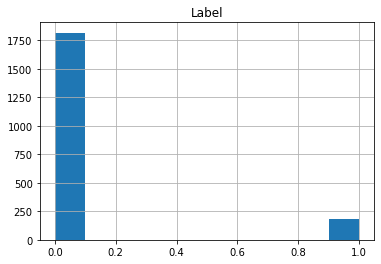

In [13]:
print("\nTrain Dataset Histogram")
train.hist()


Test Dataset Histogram


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14fb85c8d0>]],
      dtype=object)

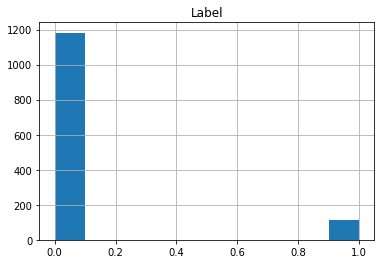

In [14]:
print("\nTest Dataset Histogram")
test.hist()

In [15]:
!pip install matplotlib
!pip install wordcloud

In [17]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**WORD CLOUD (APPEAL TO FEAR/PREJUDICE)**

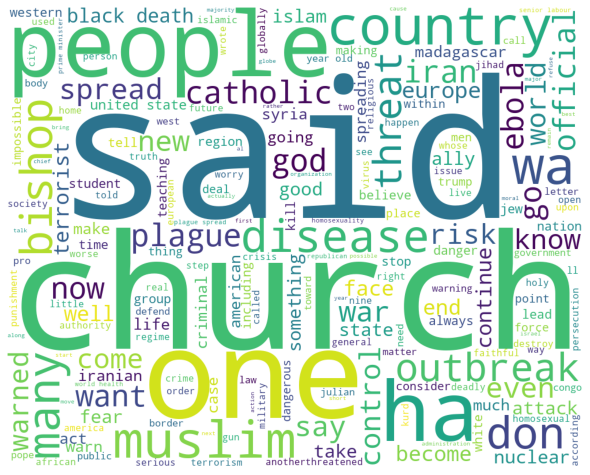

In [22]:
comment_words = '' 
stopwords = set(STOPWORDS) 
lemmatizer = WordNetLemmatizer()

# iterate through the csv file 
for val in appeal_to_fear_df.full_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split()
    
    pos_tagged = nltk.pos_tag(tokens)

    filtered_tokens = []
    for pair in pos_tagged:
        if pair[1] not in ["PRP", "MD"]:
          filtered_tokens.append(pair[0])
    
    # Converts each token into lowercase 
    for i in range(len(filtered_tokens)): 
        filtered_tokens[i] = filtered_tokens[i].lower() 
        filtered_tokens[i] = lemmatizer.lemmatize(str(filtered_tokens[i]))
      
    comment_words += " ".join(filtered_tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 